In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Charger les données ===
data = np.load("training_data.npz", allow_pickle=True)
X = np.array(data["data"], dtype=np.float32)
feature_labels = data["feature_labels"]

# Charger les labels
y = pd.read_csv("training_labels.csv")
y = y.iloc[:, 0].values 

In [85]:
from sklearn.model_selection import train_test_split

# Split the raw X and y (before any imputation or scaler)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [87]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def interpolate_or_fill(X, global_means):
    n, t, f = X.shape
    X_filled = np.empty_like(X)
    for j in range(f):
        for i in range(n):
            series = X[i, :, j]
            if np.isnan(series).all():
                X_filled[i, :, j] = global_means[j]
            else:
                x = np.arange(t)
                mask = ~np.isnan(series)
                X_filled[i, :, j] = np.interp(x, x[mask], series[mask])
    return X_filled

# Compute global means from TRAIN only
global_means = np.nanmean(X_train, axis=(0, 1))

# Apply same method to all sets using train's global means
X_train_filled = interpolate_or_fill(X_train, global_means)
X_val_filled   = interpolate_or_fill(X_val, global_means)





X_train_clip = X_train_filled.copy()
X_val_clip   = X_val_filled.copy()

n, t, f = X_train.shape
for j in range(f):
    mean = np.mean(X_train_clip[:, :, j])
    std  = np.std(X_train_clip[:, :, j])
    lower, upper = mean - 5 * std, mean + 5 * std
    X_train_clip[:, :, j] = np.clip(X_train_clip[:, :, j], lower, upper)
    X_val_clip[:, :, j]   = np.clip(X_val_clip[:, :, j], lower, upper)  # use same bounds

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_flat = X_train_clip.reshape(-1, f)
scaler.fit(X_train_flat)

# Apply
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train_clip.shape)
X_val_scaled   = scaler.transform(X_val_clip.reshape(-1, f)).reshape(X_val_clip.shape)

# Save scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')


def add_deltas(X_scaled):
    X_deltas = X_scaled[:, 1:, :] - X_scaled[:, :-1, :]
    zero_pad = np.zeros((X_scaled.shape[0], 1, X_scaled.shape[2]))
    X_deltas = np.concatenate([zero_pad, X_deltas], axis=1)
    return np.concatenate([X_scaled, X_deltas], axis=2)

X_train_scaled = add_deltas(X_train_scaled)  # shape: (n, t, 2f)
X_val_scaled   = add_deltas(X_val_scaled)



X_train_mask = (~np.isnan(X_train)).astype(np.float32)


X_train_ready = np.concatenate([X_train_scaled, X_train_mask], axis=2)  # shape: (n, t, 3f)


X_train_ready.shape

(42921, 12, 231)

In [88]:
import numpy as np

def apply_pipeline_to_val(X_val_raw, global_means, scaler, clip_means, clip_stds):
    """
    Applies interpolation, clipping, scaling, delta features, and masking to validation data.
    
    Parameters:
        X_val_raw     : np.ndarray, shape (n, t, f)
        global_means  : np.ndarray, shape (f,)
        scaler        : fitted sklearn StandardScaler
        clip_means    : np.ndarray, shape (f,), mean from train
        clip_stds     : np.ndarray, shape (f,), std from train
    
    Returns:
        X_val_ready   : np.ndarray, shape (n, t, 3f)
    """

    # === Step 1: Interpolate ===
    n, t, f = X_val_raw.shape
    X_filled = np.empty_like(X_val_raw)
    for j in range(f):
        for i in range(n):
            series = X_val_raw[i, :, j]
            if np.isnan(series).all():
                X_filled[i, :, j] = global_means[j]
            else:
                x = np.arange(t)
                mask = ~np.isnan(series)
                X_filled[i, :, j] = np.interp(x, x[mask], series[mask])

    # === Step 2: Clipping ===
    for j in range(f):
        lower = clip_means[j] - 5 * clip_stds[j]
        upper = clip_means[j] + 5 * clip_stds[j]
        X_filled[:, :, j] = np.clip(X_filled[:, :, j], lower, upper)

    # === Step 3: Scaling ===
    X_flat = X_filled.reshape(-1, f)
    X_scaled_flat = scaler.transform(X_flat)
    X_scaled = X_scaled_flat.reshape(n, t, f)

    # === Step 4: Delta features ===
    X_deltas = X_scaled[:, 1:, :] - X_scaled[:, :-1, :]
    zero_pad = np.zeros((n, 1, f))
    X_deltas = np.concatenate([zero_pad, X_deltas], axis=1)
    X_scaled_with_deltas = np.concatenate([X_scaled, X_deltas], axis=2)

    # === Step 5: Mask ===
    X_mask = (~np.isnan(X_val_raw)).astype(np.float32)

    # === Step 6: Final concat ===
    X_val_ready = np.concatenate([X_scaled_with_deltas, X_mask], axis=2)  # shape: (n, t, 3f)

    return X_val_ready


# From training pipeline
global_means = np.nanmean(X_train, axis=(0, 1))
clip_means = np.mean(X_train_filled, axis=(0, 1))
clip_stds  = np.std(X_train_filled, axis=(0, 1))
# scaler = trained StandardScaler

# Apply to val set
X_val_ready = apply_pipeline_to_val(X_val, global_means, scaler, clip_means, clip_stds)
X_val_ready.shape

(10731, 12, 231)

In [89]:
from torch.utils.data import Sampler
import random
import numpy as np

class BalancedBatchSampler(Sampler):
    def __init__(self, labels, batch_size):
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.pos_indices = np.where(self.labels == 1)[0].tolist()
        self.neg_indices = np.where(self.labels == 0)[0].tolist()
        self.batch_half = batch_size // 2

    def __iter__(self):
        # Shuffle both positive and negative indices each epoch
        random.shuffle(self.pos_indices)
        random.shuffle(self.neg_indices)

        pos_iter = iter(self.pos_indices)
        neg_iter = iter(self.neg_indices)

        while True:
            try:
                pos_batch = [next(pos_iter) for _ in range(self.batch_half)]
                neg_batch = [next(neg_iter) for _ in range(self.batch_half)]
                batch = pos_batch + neg_batch
                random.shuffle(batch)
                yield batch
            except StopIteration:
                break

    def __len__(self):
        return min(len(self.pos_indices), len(self.neg_indices)) // self.batch_half


In [90]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



# Custom Dataset class
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        # Assume X and y are NumPy arrays
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = DiabetesDataset(X_train_ready, y_train)
train_sampler = BalancedBatchSampler(y_train, batch_size=64)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)

val_dataset = DiabetesDataset(X_val_ready, y_val)

# Create DataLoaders

val_loader = DataLoader(val_dataset, batch_size=64)


In [91]:
preprocessing_artifacts = {
    "global_means": global_means,
    "clip_means": clip_means,
    "clip_stds": clip_stds,
    "scaler": scaler
}
joblib.dump(preprocessing_artifacts, "preprocessing.pkl")


['preprocessing.pkl']

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedLSTM(nn.Module):
    def __init__(self, input_size=231, hidden_size=128, num_layers=2, dropout=0.4, bidirectional=True):
        super(ImprovedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_directions = 2 if bidirectional else 1

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Attention mechanism
        self.attn_fc = nn.Linear(hidden_size * self.num_directions, 1)

        # Layer normalization after attention
        self.norm = nn.LayerNorm(hidden_size * self.num_directions)

        # Classification head
        self.head = nn.Sequential(
            nn.Linear(hidden_size * self.num_directions, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)  # Binary classification
        )

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_size * num_directions)

        # Attention scores (before softmax)
        attn_scores = self.attn_fc(lstm_out).squeeze(-1)  # (batch, seq_len)
        attn_weights = F.softmax(attn_scores, dim=1)      # (batch, seq_len)

        # Weighted sum (context vector)
        context = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)  # (batch, hidden_size * num_directions)

        # Normalize and pass to classifier
        context = self.norm(context)
        logits = self.head(context)

        return logits.squeeze()  # (batch,)


In [93]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        alpha: float or list/tuple of two floats. Weighting factor for class imbalance.
               If float, same alpha applied to both classes.
               If list/tuple: [alpha_for_0, alpha_for_1]
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = torch.tensor(alpha) if isinstance(alpha, (list, tuple)) else alpha

    def forward(self, inputs, targets):
        # Clamp probabilities for numerical stability
        probas = torch.sigmoid(inputs).clamp(min=1e-6, max=1 - 1e-6)
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        pt = probas * targets + (1 - probas) * (1 - targets)  # pt = p_t
        focal_term = (1 - pt) ** self.gamma

        if isinstance(self.alpha, torch.Tensor):
            alpha = self.alpha.to(inputs.device)
            alpha_t = alpha[1] * targets + alpha[0] * (1 - targets)
        else:
            alpha_t = self.alpha if self.alpha is not None else 1.0

        loss = alpha_t * focal_term * bce_loss

        if self.reduction == 'mean':
            return loss.mean()


In [94]:
import torch

# Count positives and negatives in training set
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()

# Compute pos_weight: how much more to weigh the positive class
pos_weight_value = n_neg / n_pos
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32)

print(f"📊 Positive samples: {n_pos}, Negative samples: {n_neg}")
print(f"⚖️ Using pos_weight = {pos_weight.item():.4f}")


📊 Positive samples: 2714, Negative samples: 40207
⚖️ Using pos_weight = 14.8147


# ***XGboost***

In [95]:
# Pour XGBoost → on aplatit (n, t, 3f) → (n, t × 3f)
X_train_flat = X_train_ready.reshape(X_train_ready.shape[0], -1)
X_val_flat   = X_val_ready.reshape(X_val_ready.shape[0], -1)


In [96]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import numpy as np
import joblib
import pickle

# Détection déséquilibre
pos_ratio = (y_train == 1).sum() / (y_train == 0).sum()

# Modèle
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=1/pos_ratio,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_flat, y_train)


c:\Users\User\Challenge-data-mias\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:19:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [97]:
y_val_prob = xgb_model.predict_proba(X_val_flat)[:, 1]

thresholds = np.linspace(0.1, 0.9, 81)
f1s = [f1_score(y_val, y_val_prob > t) for t in thresholds]
best_thresh = thresholds[np.argmax(f1s)]

print(f"📊 Best F1: {max(f1s):.4f} at threshold {best_thresh:.2f}")
print(f"✅ AUC: {roc_auc_score(y_val, y_val_prob):.4f}")
print(f"✅ Accuracy: {accuracy_score(y_val, y_val_prob > 0.5):.4f}")


📊 Best F1: 0.4735 at threshold 0.78
✅ AUC: 0.9170
✅ Accuracy: 0.8214


In [98]:
import pickle

# Save XGBoost probabilities on validation set
with open("probs_xgb.pkl", "wb") as f:
    pickle.dump(y_val_prob, f)

print("✅ Saved XGBoost validation probabilities to probs_xgb.pkl")


✅ Saved XGBoost validation probabilities to probs_xgb.pkl


In [99]:
joblib.dump(xgb_model, "xgb_model.pkl")
with open("xgb_thresh.pkl", "wb") as f:
    pickle.dump(best_thresh, f)


# ***LSTM***

Epoch 01: 100%|██████████| 84/84 [00:05<00:00, 14.92it/s]


Loss: 2.4681 | Acc: 0.9373 | AUC: 0.8806 | F1@best_thresh: 0.3793 | Prec: 0.3006 | Rec: 0.5140


Epoch 02: 100%|██████████| 84/84 [00:03<00:00, 26.20it/s]


Loss: 1.9610 | Acc: 0.9367 | AUC: 0.8918 | F1@best_thresh: 0.3958 | Prec: 0.2864 | Rec: 0.6406


Epoch 03: 100%|██████████| 84/84 [00:03<00:00, 25.24it/s]


Loss: 1.8896 | Acc: 0.9366 | AUC: 0.9000 | F1@best_thresh: 0.4248 | Prec: 0.3591 | Rec: 0.5199


Epoch 04: 100%|██████████| 84/84 [00:03<00:00, 25.99it/s]


Loss: 1.8483 | Acc: 0.9366 | AUC: 0.9004 | F1@best_thresh: 0.4123 | Prec: 0.3107 | Rec: 0.6127


Epoch 05: 100%|██████████| 84/84 [00:03<00:00, 26.22it/s]


Loss: 1.7906 | Acc: 0.9372 | AUC: 0.9056 | F1@best_thresh: 0.4269 | Prec: 0.3301 | Rec: 0.6038


Epoch 06: 100%|██████████| 84/84 [00:04<00:00, 18.35it/s]


Loss: 1.7304 | Acc: 0.9368 | AUC: 0.9063 | F1@best_thresh: 0.4407 | Prec: 0.3316 | Rec: 0.6568


Epoch 07: 100%|██████████| 84/84 [00:05<00:00, 16.55it/s]


Loss: 1.6983 | Acc: 0.9380 | AUC: 0.9049 | F1@best_thresh: 0.4328 | Prec: 0.3609 | Rec: 0.5405


Epoch 08: 100%|██████████| 84/84 [00:04<00:00, 17.27it/s]


Loss: 1.7234 | Acc: 0.9365 | AUC: 0.8994 | F1@best_thresh: 0.4137 | Prec: 0.3539 | Rec: 0.4978


Epoch 09: 100%|██████████| 84/84 [00:05<00:00, 16.71it/s]


Loss: 1.6676 | Acc: 0.9374 | AUC: 0.9086 | F1@best_thresh: 0.4491 | Prec: 0.3669 | Rec: 0.5788


Epoch 10: 100%|██████████| 84/84 [00:04<00:00, 17.56it/s]


Loss: 1.6404 | Acc: 0.9368 | AUC: 0.9072 | F1@best_thresh: 0.4451 | Prec: 0.3582 | Rec: 0.5876


Epoch 11: 100%|██████████| 84/84 [00:04<00:00, 18.30it/s]


Loss: 1.6335 | Acc: 0.9371 | AUC: 0.9111 | F1@best_thresh: 0.4478 | Prec: 0.3891 | Rec: 0.5272


Epoch 12: 100%|██████████| 84/84 [00:04<00:00, 17.90it/s]


Loss: 1.6079 | Acc: 0.9357 | AUC: 0.9090 | F1@best_thresh: 0.4484 | Prec: 0.3397 | Rec: 0.6598


Epoch 13: 100%|██████████| 84/84 [00:04<00:00, 17.78it/s]


Loss: 1.5663 | Acc: 0.9363 | AUC: 0.8990 | F1@best_thresh: 0.4210 | Prec: 0.3308 | Rec: 0.5788


Epoch 14: 100%|██████████| 84/84 [00:04<00:00, 18.63it/s]


Loss: 1.5592 | Acc: 0.9363 | AUC: 0.9116 | F1@best_thresh: 0.4606 | Prec: 0.3542 | Rec: 0.6583


Epoch 15: 100%|██████████| 84/84 [00:04<00:00, 17.68it/s]


Loss: 1.5681 | Acc: 0.9377 | AUC: 0.9098 | F1@best_thresh: 0.4613 | Prec: 0.3815 | Rec: 0.5832


Epoch 16: 100%|██████████| 84/84 [00:04<00:00, 18.28it/s]


Loss: 1.4958 | Acc: 0.9395 | AUC: 0.9084 | F1@best_thresh: 0.4594 | Prec: 0.3541 | Rec: 0.6539


Epoch 17: 100%|██████████| 84/84 [00:04<00:00, 17.81it/s]


Loss: 1.4070 | Acc: 0.9388 | AUC: 0.9067 | F1@best_thresh: 0.4567 | Prec: 0.3561 | Rec: 0.6362


Epoch 18: 100%|██████████| 84/84 [00:04<00:00, 18.53it/s]


Loss: 1.4603 | Acc: 0.9390 | AUC: 0.9078 | F1@best_thresh: 0.4567 | Prec: 0.3429 | Rec: 0.6834


Epoch 19: 100%|██████████| 84/84 [00:04<00:00, 18.71it/s]


Loss: 1.5437 | Acc: 0.9389 | AUC: 0.9070 | F1@best_thresh: 0.4617 | Prec: 0.3586 | Rec: 0.6480


Epoch 20: 100%|██████████| 84/84 [00:04<00:00, 17.50it/s]


Loss: 1.4060 | Acc: 0.9366 | AUC: 0.9006 | F1@best_thresh: 0.4655 | Prec: 0.3742 | Rec: 0.6156

✅ Best F1-score: 0.4655 at epoch 20, threshold = 0.39


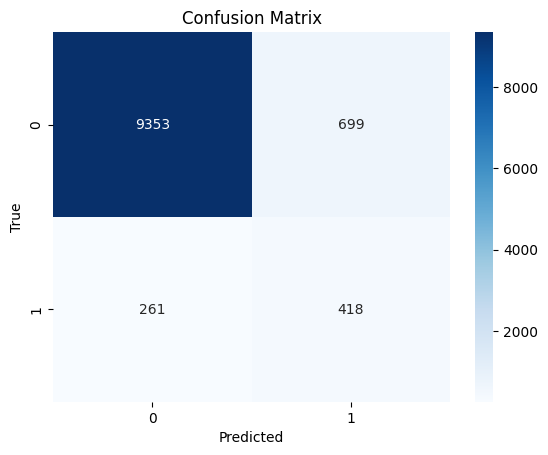

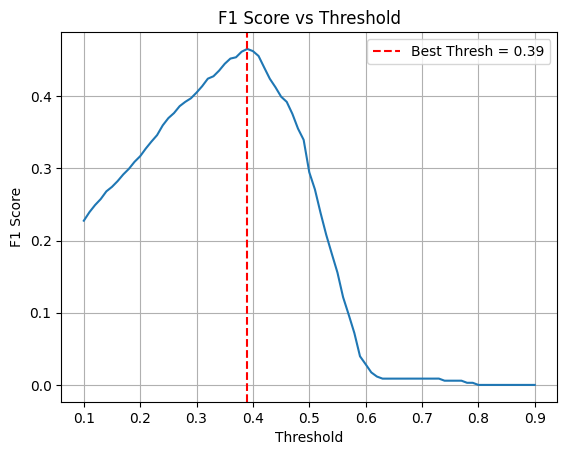

✅ Saved LSTM probabilities as probs_lstm.pkl


In [100]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Compute class imbalance weights for FocalLoss ====
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
alpha_0 = n_neg / (n_pos + n_neg)  # class 0
alpha_1 = n_pos / (n_pos + n_neg)  # class 1
alpha = torch.tensor([alpha_0, alpha_1], dtype=torch.float32).to(device)

# ==== Model, Loss, Optimizer, Scheduler ====
model = ImprovedLSTM(input_size=X_train_ready.shape[2]).to(device)
criterion = FocalLoss(alpha=alpha, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# ==== Training Loop ====
def train_model(train_loader, val_loader, model, criterion, optimizer, scheduler, max_epochs=20, patience=5):
    def evaluate(model, dataloader):
        model.eval()
        y_true, y_prob = [], []
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(device)
                logits = model(X_batch)
                probs = torch.sigmoid(logits).cpu().numpy()
                y_prob.extend(probs)
                y_true.extend(y_batch.numpy())
        return np.array(y_true), np.array(y_prob)

    best_f1, best_epoch, no_improve = 0, 0, 0
    best_thresh = 0.5
    all_metrics = {}

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch:02d}"):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # === Validation evaluation ===
        y_true, y_prob = evaluate(model, val_loader)
        thresholds = np.linspace(0.1, 0.9, 81)
        f1_scores = [f1_score(y_true, y_prob > t) for t in thresholds]
        current_best_thresh = thresholds[np.argmax(f1_scores)]
        current_f1 = max(f1_scores)
        acc = accuracy_score(y_true, y_prob > 0.5)
        auc = roc_auc_score(y_true, y_prob)
        prec = precision_score(y_true, y_prob > current_best_thresh)
        rec = recall_score(y_true, y_prob > current_best_thresh)

        scheduler.step(current_f1)

        print(f"Loss: {total_loss:.4f} | Acc: {acc:.4f} | AUC: {auc:.4f} | F1@best_thresh: {current_f1:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")

        # Save best model
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_thresh = current_best_thresh
            best_epoch = epoch
            no_improve = 0
            torch.save(model.state_dict(), "best_model_lstm.pth")
            with open("best_thresh.pkl", "wb") as f:
                pickle.dump(best_thresh, f)
            all_metrics = {
                'y_true': y_true,
                'y_prob': y_prob,
                'best_thresh': best_thresh
            }
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"⏹️ Early stopping at epoch {epoch}")
            break

    print(f"\n✅ Best F1-score: {best_f1:.4f} at epoch {best_epoch}, threshold = {best_thresh:.2f}")
    return model, best_thresh, all_metrics

# === Train ===
trained_model, best_threshold, all_metrics = train_model(
    train_loader, val_loader,
    model, criterion, optimizer, scheduler,
    max_epochs=20, patience=5
)

# === Final evaluation ===
y_true = all_metrics['y_true']
y_prob = all_metrics['y_prob']
best_thresh = all_metrics['best_thresh']
y_pred = (y_prob > best_thresh).astype(int)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# === Plot F1 vs threshold ===
thresholds = np.linspace(0.1, 0.9, 81)
f1s = [f1_score(y_true, y_prob > t) for t in thresholds]
plt.plot(thresholds, f1s)
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Thresh = {best_thresh:.2f}')
plt.title("F1 Score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.show()


# === Save LSTM probs for fusion ===
with open("probs_lstm.pkl", "wb") as f:
    pickle.dump(y_prob, f)
print("✅ Saved LSTM probabilities as probs_lstm.pkl")


# ***CNN***

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesCNN(nn.Module):
    def __init__(self, input_size, num_filters=64, kernel_size=3, dropout=0.3):
        super(TimeSeriesCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm1d(num_filters)

        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm1d(num_filters)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout)

        self.head = nn.Sequential(
            nn.Linear(num_filters, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x shape: (batch, time, features)
        x = x.permute(0, 2, 1)  # → (batch, features, time)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.global_pool(x).squeeze(-1)  # → (batch, num_filters)
        x = self.dropout(x)
        logits = self.head(x)
        return logits.squeeze()


In [102]:

# === CNN Training Function ===
def train_model(train_loader, val_loader, y_train):
    model = TimeSeriesCNN(input_size=X_train_ready.shape[2]).to(device)

    # Class imbalance handling for focal loss
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    alpha = torch.tensor([
        n_neg / (n_pos + n_neg),
        n_pos / (n_pos + n_neg)
    ], dtype=torch.float32).to(device)

    criterion = FocalLoss(alpha=alpha, gamma=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    def evaluate(model, dataloader):
        model.eval()
        y_true, y_prob = [], []
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(device)
                logits = model(X_batch)
                probs = torch.sigmoid(logits).cpu().numpy()
                y_prob.extend(probs)
                y_true.extend(y_batch.numpy())
        return np.array(y_true), np.array(y_prob)

    best_f1, best_epoch, best_thresh = 0, 0, 0.5
    no_improve = 0
    patience = 5
    probs_cnn = None

    for epoch in range(1, 31):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch:02d}"):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate
        y_true, y_prob = evaluate(model, val_loader)
        thresholds = np.linspace(0.1, 0.9, 81)
        f1s = [f1_score(y_true, y_prob > t) for t in thresholds]
        current_thresh = thresholds[np.argmax(f1s)]
        current_f1 = max(f1s)
        acc = accuracy_score(y_true, y_prob > 0.5)
        auc = roc_auc_score(y_true, y_prob)
        prec = precision_score(y_true, y_prob > current_thresh)
        rec = recall_score(y_true, y_prob > current_thresh)

        print(f"Loss: {total_loss:.4f} | Acc: {acc:.4f} | AUC: {auc:.4f} | F1: {current_f1:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")

        # Save best
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_thresh = current_thresh
            best_epoch = epoch
            no_improve = 0
            probs_cnn = y_prob
            torch.save(model.state_dict(), "best_model_cnn.pth")
            with open("best_thresh_cnn.pkl", "wb") as f:
                pickle.dump(best_thresh, f)
        else:
            no_improve += 1

        scheduler.step(current_f1)

        if no_improve >= patience:
            print(f"⏹️ Early stopping at epoch {epoch}")
            break

    print(f"\n✅ Best F1-score: {best_f1:.4f} at epoch {best_epoch} | Best threshold: {best_thresh:.2f}")
    return model, best_thresh, probs_cnn

trained_cnn, threshold_cnn, probs_cnn = train_model(train_loader, val_loader, y_train)


Epoch 01: 100%|██████████| 84/84 [00:01<00:00, 60.29it/s]


Loss: 2.5948 | Acc: 0.9367 | AUC: 0.8866 | F1: 0.3849 | Prec: 0.3036 | Rec: 0.5258


Epoch 02: 100%|██████████| 84/84 [00:00<00:00, 121.23it/s]


Loss: 1.9841 | Acc: 0.9367 | AUC: 0.9006 | F1: 0.4219 | Prec: 0.3282 | Rec: 0.5906


Epoch 03: 100%|██████████| 84/84 [00:00<00:00, 125.40it/s]


Loss: 1.8658 | Acc: 0.9368 | AUC: 0.8958 | F1: 0.4070 | Prec: 0.3044 | Rec: 0.6141


Epoch 04: 100%|██████████| 84/84 [00:00<00:00, 129.15it/s]


Loss: 1.8520 | Acc: 0.9371 | AUC: 0.8969 | F1: 0.4214 | Prec: 0.3289 | Rec: 0.5862


Epoch 05: 100%|██████████| 84/84 [00:00<00:00, 123.98it/s]


Loss: 1.8604 | Acc: 0.9367 | AUC: 0.9037 | F1: 0.4269 | Prec: 0.3223 | Rec: 0.6318


Epoch 06: 100%|██████████| 84/84 [00:00<00:00, 112.27it/s]


Loss: 1.7707 | Acc: 0.9368 | AUC: 0.9053 | F1: 0.4259 | Prec: 0.3747 | Rec: 0.4934


Epoch 07: 100%|██████████| 84/84 [00:00<00:00, 129.22it/s]


Loss: 1.7463 | Acc: 0.9369 | AUC: 0.9052 | F1: 0.4289 | Prec: 0.3494 | Rec: 0.5552


Epoch 08: 100%|██████████| 84/84 [00:00<00:00, 127.72it/s]


Loss: 1.7281 | Acc: 0.9389 | AUC: 0.9076 | F1: 0.4257 | Prec: 0.4010 | Rec: 0.4536


Epoch 09: 100%|██████████| 84/84 [00:00<00:00, 126.35it/s]


Loss: 1.7896 | Acc: 0.9377 | AUC: 0.9106 | F1: 0.4363 | Prec: 0.3315 | Rec: 0.6377


Epoch 10: 100%|██████████| 84/84 [00:00<00:00, 123.16it/s]


Loss: 1.7099 | Acc: 0.9390 | AUC: 0.9086 | F1: 0.4405 | Prec: 0.3472 | Rec: 0.6024


Epoch 11: 100%|██████████| 84/84 [00:00<00:00, 127.38it/s]


Loss: 1.7118 | Acc: 0.9371 | AUC: 0.9090 | F1: 0.4487 | Prec: 0.3575 | Rec: 0.6024


Epoch 12: 100%|██████████| 84/84 [00:00<00:00, 126.21it/s]


Loss: 1.6816 | Acc: 0.9399 | AUC: 0.9084 | F1: 0.4412 | Prec: 0.4230 | Rec: 0.4610


Epoch 13: 100%|██████████| 84/84 [00:00<00:00, 130.09it/s]


Loss: 1.7495 | Acc: 0.9372 | AUC: 0.9086 | F1: 0.4455 | Prec: 0.3827 | Rec: 0.5331


Epoch 14: 100%|██████████| 84/84 [00:00<00:00, 113.08it/s]


Loss: 1.6666 | Acc: 0.9380 | AUC: 0.9099 | F1: 0.4452 | Prec: 0.3623 | Rec: 0.5773


Epoch 15: 100%|██████████| 84/84 [00:00<00:00, 124.04it/s]


Loss: 1.6774 | Acc: 0.9398 | AUC: 0.9081 | F1: 0.4594 | Prec: 0.3862 | Rec: 0.5670


Epoch 16: 100%|██████████| 84/84 [00:00<00:00, 127.81it/s]


Loss: 1.6136 | Acc: 0.9394 | AUC: 0.9064 | F1: 0.4426 | Prec: 0.3726 | Rec: 0.5449


Epoch 17: 100%|██████████| 84/84 [00:00<00:00, 125.35it/s]


Loss: 1.6929 | Acc: 0.9397 | AUC: 0.9078 | F1: 0.4387 | Prec: 0.3904 | Rec: 0.5007


Epoch 18: 100%|██████████| 84/84 [00:00<00:00, 119.83it/s]


Loss: 1.6711 | Acc: 0.9368 | AUC: 0.9082 | F1: 0.4414 | Prec: 0.3812 | Rec: 0.5243


Epoch 19: 100%|██████████| 84/84 [00:00<00:00, 128.81it/s]


Loss: 1.6242 | Acc: 0.9404 | AUC: 0.9100 | F1: 0.4561 | Prec: 0.3546 | Rec: 0.6392


Epoch 20: 100%|██████████| 84/84 [00:00<00:00, 128.72it/s]


Loss: 1.5761 | Acc: 0.9400 | AUC: 0.9087 | F1: 0.4474 | Prec: 0.3695 | Rec: 0.5670
⏹️ Early stopping at epoch 20

✅ Best F1-score: 0.4594 at epoch 15 | Best threshold: 0.40


# ***fusion***

In [103]:
with open("probs_lstm.pkl", "rb") as f:
    probs_lstm = pickle.load(f)


In [104]:
import numpy as np
import pickle
from sklearn.metrics import f1_score
import numpy as np
import pickle
from sklearn.metrics import f1_score, precision_score, roc_auc_score

# Charger les probabilités de validation
with open("probs_lstm.pkl", "rb") as f:
    probs_lstm = pickle.load(f)

with open("probs_xgb.pkl", "rb") as f:
    probs_xgb = pickle.load(f)

y_true = y_val
#Recherche des meilleurs poids et seuil
thresholds = np.linspace(0.1, 0.9, 81)
best_f1 = 0
best_w = (1/3, 1/3, 1/3)
best_thresh = 0.5
best_auc = 0
best_precision = 0

for w_lstm in np.linspace(0, 1, 11):
    for w_cnn in np.linspace(0, 1 - w_lstm, 11):
        w_xgb = 1.0 - w_lstm - w_cnn
        if w_xgb < 0 or w_xgb > 1:
            continue

        fused_probs = (
            w_lstm * probs_lstm +
            w_cnn * probs_cnn +
            w_xgb * probs_xgb
        )

        for t in thresholds:
            preds = (fused_probs > t).astype(int)
            f1 = f1_score(y_true, preds)
            precision = precision_score(y_true, preds, zero_division=0)
            try:
                auc = roc_auc_score(y_true, fused_probs)
            except ValueError:
                auc = 0.0  # In case y_true contains only one class

            if f1 > best_f1:
                best_f1 = f1
                best_auc = auc
                best_precision = precision
                best_w = (w_lstm, w_cnn, w_xgb)
                best_thresh = t

# Résultats
print(f"🎯 Best F1 Score:     {best_f1:.4f}")
print(f"📈 Best AUC:          {best_auc:.4f}")
print(f"🎯 Best Precision:    {best_precision:.4f}")
print(f"⚖️  Best weights -> LSTM: {best_w[0]:.2f} | CNN: {best_w[1]:.2f} | XGB: {best_w[2]:.2f}")
print(f"📏 Best threshold:    {best_thresh:.2f}")

# Sauvegarde
with open("fusion_weights.pkl", "wb") as f:
    pickle.dump(best_w, f)

with open("fusion_thresh.pkl", "wb") as f:
    pickle.dump(best_thresh, f)

print("✅ Saved fusion_weights.pkl and fusion_thresh.pkl")

🎯 Best F1 Score:     0.4887
📈 Best AUC:          0.9214
🎯 Best Precision:    0.3855
⚖️  Best weights -> LSTM: 0.20 | CNN: 0.24 | XGB: 0.56
📏 Best threshold:    0.60
✅ Saved fusion_weights.pkl and fusion_thresh.pkl


In [105]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import joblib
import pickle
from torch.utils.data import Dataset, DataLoader
from xgboost import XGBClassifier

# ==== Load preprocessing artifacts ====
scaler = joblib.load("scaler.pkl")

with open("fusion_weights.pkl", "rb") as f:
    best_w = pickle.load(f)  # (w_lstm, w_cnn, w_xgb)

with open("fusion_thresh.pkl", "rb") as f:
    best_thresh = pickle.load(f)

# ==== Load and preprocess test data ====
data_test = np.load("evaluation_data.npz", allow_pickle=True)
X_test = np.array(data_test["data"], dtype=np.float32)

# Load training stats (from memory or reload)
global_means = np.nanmean(X_train, axis=(0, 1))
clip_means = np.mean(X_train_filled, axis=(0, 1))
clip_stds = np.std(X_train_filled, axis=(0, 1))
# Apply the same column selection to X_test


X_test_ready = apply_pipeline_to_val(X_test, global_means, scaler, clip_means, clip_stds)

# ==== Prepare PyTorch loader for LSTM and CNN ====
class TestDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

test_loader = DataLoader(TestDataset(X_test_ready), batch_size=64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Load LSTM ====
model_lstm = ImprovedLSTM(input_size=X_test_ready.shape[2]).to(device)
model_lstm.load_state_dict(torch.load("best_model_lstm.pth"))
model_lstm.eval()

# ==== Load CNN ====
model_cnn = TimeSeriesCNN(input_size=X_test_ready.shape[2]).to(device)
model_cnn.load_state_dict(torch.load("best_model_cnn.pth"))
model_cnn.eval()

# ==== Predict LSTM & CNN ====
probs_lstm, probs_cnn = [], []

with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)

        out_lstm = model_lstm(X_batch)
        out_cnn = model_cnn(X_batch)

        probs_lstm.extend(torch.sigmoid(out_lstm).cpu().numpy())
        probs_cnn.extend(torch.sigmoid(out_cnn).cpu().numpy())

probs_lstm = np.array(probs_lstm).flatten()
probs_cnn = np.array(probs_cnn).flatten()

# ==== Predict XGBoost ====
# ➤ Flatten features over time
X_test_xgb = X_test_ready.reshape(X_test_ready.shape[0], -1)

# ➤ Load trained model
xgb_model = pickle.load(open("xgb_model.pkl", "rb"))

# ➤ Get probabilities
probs_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

# ==== Weighted fusion ====
w_lstm, w_cnn, w_xgb = best_w
probs_fused = w_lstm * probs_lstm + w_cnn * probs_cnn + w_xgb * probs_xgb

# ==== Final prediction ====
y_test_pred = (probs_fused > best_thresh).astype(int)

# ==== Save CSV ====
submission = pd.DataFrame({
    "Id": np.arange(len(y_test_pred)),
    "Label": y_test_pred
})
submission.to_csv("final_submission.csv", index=False)
print("✅ Submission saved as final_submission.csv")


✅ Submission saved as final_submission.csv
